# <center>Advanced Machine Learning, Spring 2023</center>
### <center>Home Assignment 2 – Ensemble Learning</center>


In [50]:
import seaborn as sns
import pandas as pd
import numpy as np

from abc import ABC, abstractmethod
from dataclasses import dataclass
from sklearn.datasets import make_classification
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, auc, classification_report 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

In [51]:
import warnings

warnings.filterwarnings('ignore')

<br></br>
## Part 0 - Generate Datasets

In [52]:
@dataclass(frozen=True)
class Dataset:
    id: int
    X_train: np.ndarray
    X_test: np.ndarray
    y_train: np.ndarray
    y_test: np.ndarray


data = [
    make_classification(n_samples=5000, n_features=50, n_classes=2, n_informative=10, n_clusters_per_class=3), 
    make_classification(n_samples=5000, n_features=25, n_classes=2, n_informative=5, weights=[0.35])
]

for i in range(len(data)):
    data[i][1][:] = data[i][1][:]*2 - 1

datasets = [
    Dataset(0, *train_test_split(*data[0], test_size=0.3)),
    Dataset(1, *train_test_split(*data[1], test_size=0.25)),
]

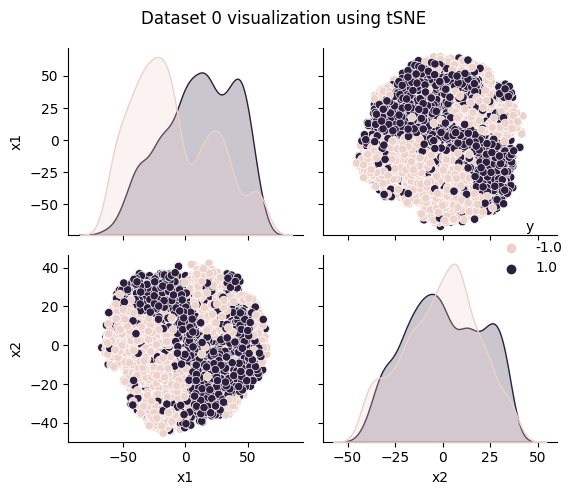

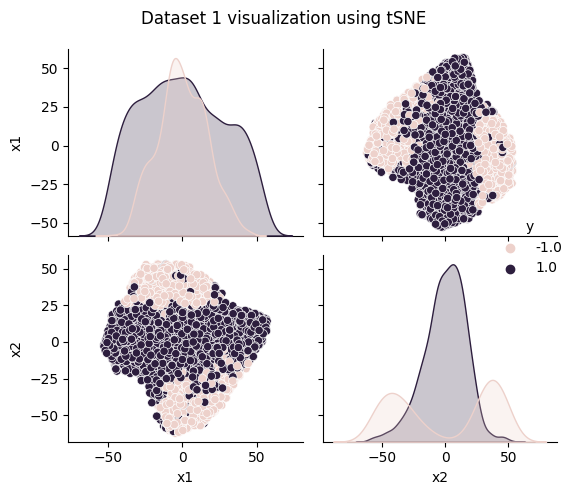

In [53]:
def visualize_datasets(data):
    for i, (X, y) in enumerate(data):
        reduced_X = TSNE().fit_transform(X)
        df = pd.DataFrame(np.column_stack([reduced_X, y]), columns=['x1', 'x2', 'y'])
        g = sns.pairplot(df, hue='y')
        g.figure.suptitle(f'Dataset {i} visualization using tSNE')
        g.figure.tight_layout()

visualize_datasets(data)

<br></br>
## Part 1 - GBRT

In [54]:
class BoostingBase(ABC):
    def __init__(self, T: int) -> None:
        self._T = T
    
    @abstractmethod
    def _H(self, X):
        pass

    def predict(self, X):
        y_hat = self._H(X)
        return np.sign(y_hat)
    
    def score(self, X , y):
        pred = self.predict(X)
        return (y == pred).sum() / y.shape[0]

In [59]:
def evaluate_classifier(model, dataset, y_hat=None, ax=None, verbose=True):
    if y_hat is None:
        y_hat = model._H(dataset.X_test)
    fpr, tpr, _ = roc_curve(dataset.y_test, y_hat)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Dataset {dataset.id} best {model.__class__.__name__} estimator')
    display.plot(ax=ax)

    if verbose:
        print(classification_report(dataset.y_test, model.predict(dataset.X_test)))

In [60]:
class GBRT(BoostingBase):
    def __init__(self, alpha=0.1, T=100, max_depth=2) -> None:
        super().__init__(T)
        self._alpha = alpha
        self._max_depth = max_depth
        self._trees = None
        
    def fit(self, X, y):
        self._trees = []
        t = y.astype(float)
        for _ in range(self._T):  
            h = DecisionTreeRegressor(max_depth=self._max_depth)
            h.fit(X, t)
            self._trees.append(h)
            t -= self._alpha * h.predict(X)

    def _H(self, X):
        y_hat = np.zeros(X.shape[0])
        for h in self._trees:
            y_hat += self._alpha * h.predict(X)
        return y_hat
    
    def __repr__(self) -> str:
        return f"GBRT - T: {self._T}, alpha: {self._alpha}, max_depth: {self._max_depth}"

In [61]:
def run_GBRT_expriment(Ts, alphas, max_depths):
    results = pd.DataFrame(columns=['dataset', 'T', 'alpha', 'max_depth', 'accuracy'])
    best_models = []
    for i, dataset in enumerate(datasets):
        # hyperparams tunning
        best_model = None
        for T in Ts:
            for alpha in alphas:
                for max_depth in max_depths:
                    gbrt = GBRT(alpha=alpha, T=T, max_depth=max_depth)
                    gbrt.fit(dataset.X_train, dataset.y_train)
                    accuracy = gbrt.score(dataset.X_test, dataset.y_test)
                    results.loc[len(results)] = [int(i), T, alpha, max_depth, accuracy]
                    
                    if best_model is None or accuracy > best_model['accuracy']:
                        best_model = {'model': gbrt, 'accuracy': accuracy}   
        
        best_models.append(best_model)
        
        # best model results analysis
        print(f'Dataset {i} best model: {best_model}')
        evaluate_classifier(best_model['model'], dataset)
        
    return results, best_models

Dataset 0 best model: {'model': GBRT - T: 200, alpha: 0.1, max_depth: 2, 'accuracy': 0.864}
              precision    recall  f1-score   support

          -1       0.85      0.89      0.87       754
           1       0.88      0.84      0.86       746

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500

Dataset 1 best model: {'model': GBRT - T: 200, alpha: 0.5, max_depth: 2, 'accuracy': 0.94}
              precision    recall  f1-score   support

          -1       0.92      0.91      0.92       448
           1       0.95      0.96      0.95       802

    accuracy                           0.94      1250
   macro avg       0.94      0.93      0.93      1250
weighted avg       0.94      0.94      0.94      1250

CPU times: user 1min 26s, sys: 1.2 s, total: 1min 27s
Wall time: 1min 28s


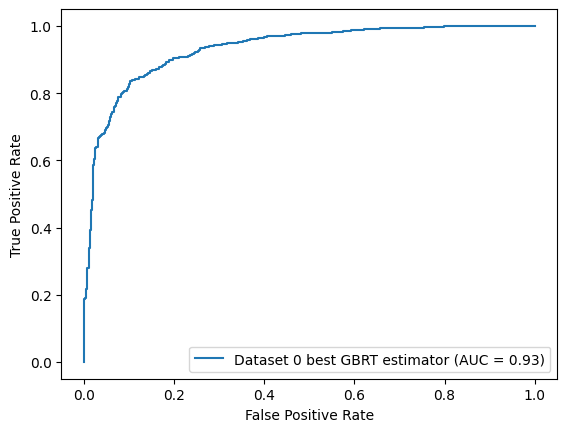

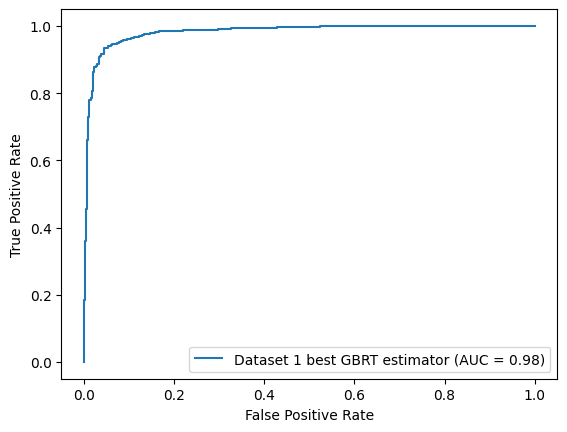

In [62]:
%%time

gbrt_results, gbrt_best_models = run_GBRT_expriment(
    Ts=[10, 50, 100, 200],
    alphas=[1, 0.5, 0.1],
    max_depths=[1,2]
)

<br></br>
## Part 2 - AdaBoost

In [63]:
class AdaBoost(BoostingBase):
    def __init__(self, T=100) -> None:
        super().__init__(T)
        self._stumps = None

    def fit(self, X, y):
        self._stumps = []
        w = np.ones_like(y) / y.shape[0]
        for _ in range(self._T):
            h = DecisionTreeRegressor(max_depth=1)
            h.fit(X, y, sample_weight=w)
            pred = np.sign(h.predict(X))
            eps = w[pred != y].sum()
            
            if eps < 0.5:
                alpha = 0.5 * np.log((1-eps)/eps)
                self._stumps.append((h, alpha))
                w *= (np.exp(-alpha * h.predict(X) * y) / (2 * np.sqrt(eps*(1-eps))))
            else:
                break

    def _H(self, X):
        y_hat = np.zeros(X.shape[0])
        for h, alpha in self._stumps:
            y_hat += alpha * h.predict(X)
        return y_hat

    def __repr__(self) -> str:
        return f"AdaBoost - T: {self._T}"

In [64]:
def run_Ada_expriment(Ts):
    results = pd.DataFrame(columns=['dataset', 'T', 'accuracy'])
    best_models = []
    for i, dataset in enumerate(datasets):
        # hyperparams tunning
        best_model = None
        for T in Ts:
            ada = AdaBoost(T=T)
            ada.fit(dataset.X_train, dataset.y_train)
            accuracy = ada.score(dataset.X_test, dataset.y_test)
            results.loc[len(results)] = [int(i), T, accuracy]
            
            if best_model is None or accuracy > best_model['accuracy']:
                best_model = {'model': ada, 'accuracy': accuracy}
        
        best_models.append(best_model)
        
        # best model results analysis
        print(f'Dataset {i} best model: {best_model}')
        evaluate_classifier(best_model['model'], dataset)
        
    return results, best_models

Dataset 0 best model: {'model': AdaBoost - T: 100, 'accuracy': 0.7946666666666666}
              precision    recall  f1-score   support

          -1       0.78      0.82      0.80       754
           1       0.81      0.77      0.79       746

    accuracy                           0.79      1500
   macro avg       0.80      0.79      0.79      1500
weighted avg       0.80      0.79      0.79      1500

Dataset 1 best model: {'model': AdaBoost - T: 200, 'accuracy': 0.776}
              precision    recall  f1-score   support

          -1       0.82      0.48      0.60       448
           1       0.76      0.94      0.84       802

    accuracy                           0.78      1250
   macro avg       0.79      0.71      0.72      1250
weighted avg       0.78      0.78      0.76      1250



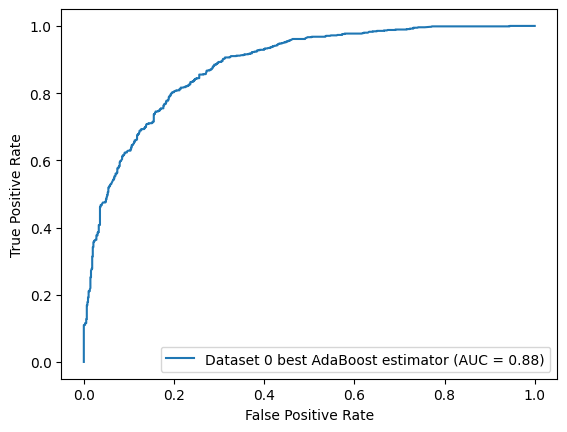

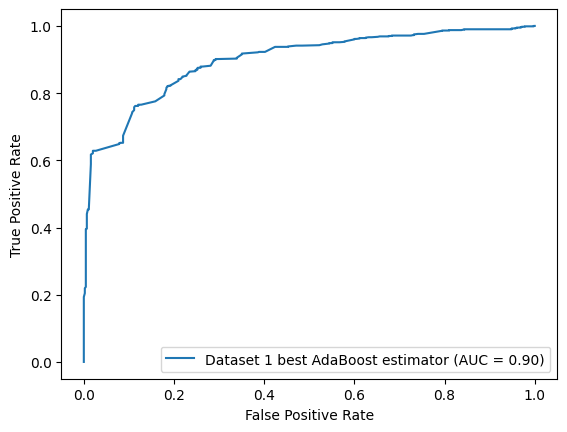

In [65]:
ada_results, ada_best_models = run_Ada_expriment(Ts=[10, 50, 100, 200])

<br></br>
## Part 3 - Logistic Regression Classifier (Baseline)

In [66]:
lr = LogisticRegression()
lr.fit(datasets[0].X_train, datasets[0].y_train)
lr.score(datasets[0].X_test, datasets[0].y_test)

0.8226666666666667

In [67]:
def run_logistic_expriment(C):
    results = pd.DataFrame(columns=['dataset', 'C', 'accuracy'])
    best_models = []
    for i, dataset in enumerate(datasets):
        # hyperparams tunning
        best_model = None
        for c in C:
            lr = LogisticRegression(C=c ,class_weight='balanced')
            lr.fit(dataset.X_train, dataset.y_train)
            accuracy = lr.score(dataset.X_test, dataset.y_test)
            results.loc[len(results)] = [int(i), c, accuracy]
            
            if best_model is None or accuracy > best_model['accuracy']:
                best_model = {'model': lr, 'accuracy': accuracy}
        
        best_models.append(best_model)
        
        # best model results analysis
        print(f'Dataset {i} best model: {best_model}')
        evaluate_classifier(best_model['model'], dataset, y_hat=best_model['model'].predict_proba(dataset.X_test)[:,1])
        
    return results, best_models

Dataset 0 best model: {'model': LogisticRegression(C=0.5, class_weight='balanced'), 'accuracy': 0.8226666666666667}
              precision    recall  f1-score   support

          -1       0.82      0.84      0.83       754
           1       0.83      0.81      0.82       746

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500

Dataset 1 best model: {'model': LogisticRegression(C=0.1, class_weight='balanced'), 'accuracy': 0.8168}
              precision    recall  f1-score   support

          -1       0.71      0.82      0.76       448
           1       0.89      0.81      0.85       802

    accuracy                           0.82      1250
   macro avg       0.80      0.82      0.81      1250
weighted avg       0.83      0.82      0.82      1250



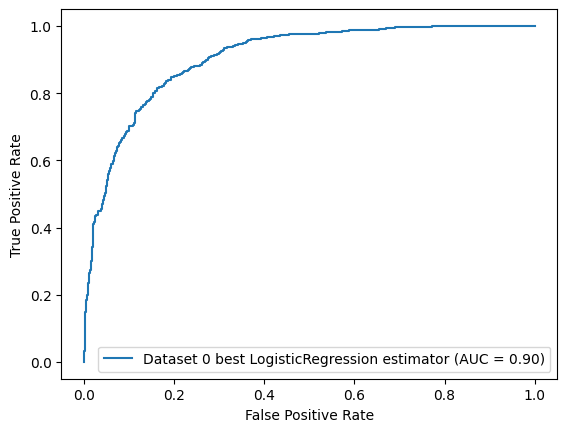

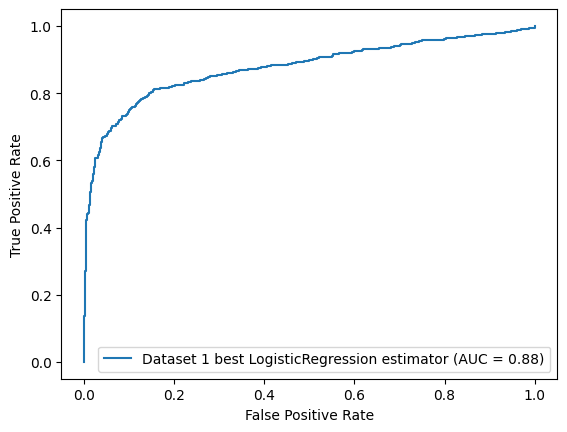

In [68]:
lr_results, lr_best_models = run_logistic_expriment(C=[0.1, 0.5, 1, 2])

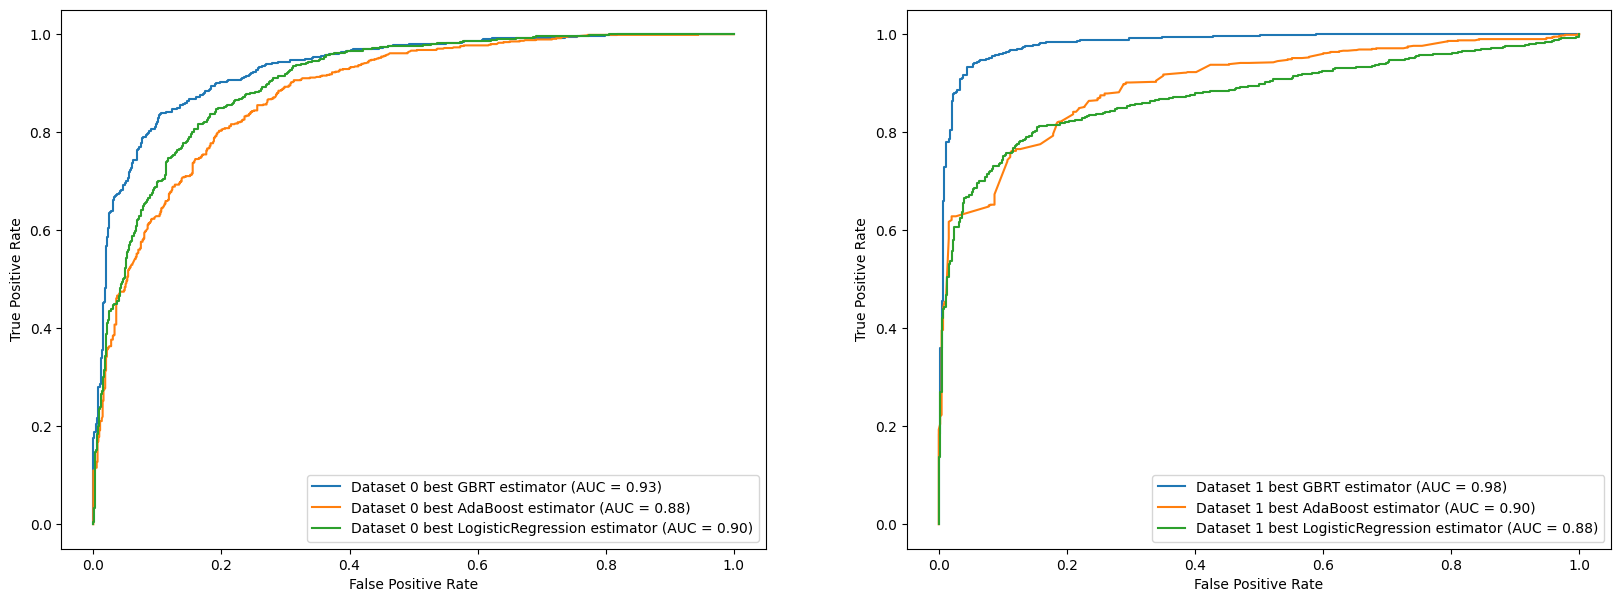

In [69]:
# plot roc curve for all best models
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20, 7))
for i, model in enumerate(gbrt_best_models):
    evaluate_classifier(model['model'], datasets[i], ax=ax[i], verbose=False)
for i, model in enumerate(ada_best_models):
    evaluate_classifier(model['model'], datasets[i], ax=ax[i], verbose=False)
for i, model in enumerate(lr_best_models):
    evaluate_classifier(model['model'], datasets[i], ax=ax[i], verbose=False, y_hat=model['model'].predict_proba(datasets[i].X_test)[:,1])
